In [0]:
#importing libraries
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from statistics import mean 
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

In [2]:
#mounting my drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
X1 =  np.load('/content/drive/My Drive/normalized_phase_diff.npy')
X2 = np.load('/content/drive/My Drive/normalized_amplitude_reshaped.npy')
y =  np.load('/content/drive/My Drive/labels.npy')

INPUT_COUNT = X1.shape[1]
X1 = X1 - np.transpose(X1.mean(axis=1).repeat(INPUT_COUNT).reshape(INPUT_COUNT, -1))
X1 = np.absolute(X1)

X2 = X2 - np.transpose(X2.mean(axis=1).repeat(INPUT_COUNT).reshape(INPUT_COUNT, -1))
X2 = np.absolute(X2)

X = np.append(X1, X2, axis=1)

del X1, X2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1999596)

del X, y


INPUT_COUNT = X_test.shape[1]


train = np.append(X_train, y_train.reshape(-1, 1), axis=1)

del X_train

nonPS = train[y_train==0]
PS = train[y_train==1]

del train, y_train

train_samples=[]
given_ratio = 57

km = (len(nonPS)+len(PS))/((given_ratio+1)*len(PS))

data_size_int_counts = 40#arbitary number of choice
data_sizes_interval = []

for i in range(data_size_int_counts):
  ds = (1 + (i)*(max(0, i-2) + 1))/(1 + (data_size_int_counts)*(max(0, data_size_int_counts-2) + 1)) * km
  data_sizes_interval.append(ds)


data_sizes=[]

for k in data_sizes_interval:
  n_non_PS = int(given_ratio*k*len(PS))
  n_PS = int(k*len(PS))
  data_sizes.append([n_non_PS, n_PS])



for data_size in data_sizes:

  nonPS_sample = resample(nonPS, n_samples=data_size[0])
  PS_sample = resample(PS, n_samples=data_size[1])

  train_sample = torch.tensor(np.append(nonPS_sample, PS_sample, axis=0))

  np.random.shuffle(train_sample)

  train_samples.append(train_sample)

del nonPS, PS


test_samples=torch.tensor(np.append(X_test, y_test.reshape(-1, 1), axis=1))

del X_test, y_test

In [0]:
#class to instantnize network object
class Net(nn.Module):
    def __init__(self, h_layers):
        super().__init__()

        self.h_layers = h_layers
        
        self.input = nn.Sequential(
            nn.Linear(INPUT_COUNT, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        
        self.hidden = nn.ModuleList()
        for k in range(h_layers-1):
            self.hidden.append(nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        ))
        
        self.output = nn.Linear(1024, 1) if h_layers>0 else nn.Linear(INPUT_COUNT, 1)
        
        self.drop_layer = nn.Dropout(p=0.25)
    
    def forward(self, X):#forward propogation through network

        if self.h_layers:
          X = self.input(X)
          X = self.drop_layer(X)
        for layer in self.hidden:
          X = layer(X)
          X = self.drop_layer(X)
        X = self.output(X)
        return torch.sigmoid(X)

In [0]:
# function to calculate metrics for current batch
def calc_metrics(y_pred, y_true):
  epsilon = 1e-7
  '''rounded each element to either 0 for less than 0.5 or 1 for greater than 0.5'''
  y_pred = torch.round(y_pred)

  
  tp = (y_true * y_pred).sum() # true positive
  fp = ((1-y_true) * y_pred).sum() # false positive
  fn = (y_true * (1-y_pred)).sum()# calculating false negative

  precision = tp / (tp + fp + epsilon)
  recall = tp / (tp + fn + epsilon )
  f1 = 2*tp / (2*tp + fp + fn + epsilon)

  return f1, precision, recall


In [0]:
#class to create F1_loss object instance
class F1_Loss(nn.Module):
    
    def __init__(self, epsilon=1e-7):
        super().__init__()
        self.epsilon = epsilon
        
    def forward(self, y_pred, y_true,):
        
        tp = (y_true * y_pred).sum()
        fp = ((1 - y_true) * y_pred).sum()
        fn = (y_true * (1 - y_pred)).sum()


        f1 = 2*tp / (2*tp + fp + fn + self.epsilon)
        return 1 - f1

f1_loss = F1_Loss()

In [0]:
#instantizing loss_function 
loss_function = f1_loss

In [0]:
#function to calculate loss and metrics
def calc_loss_n_metrics(outputs, batch_y):
  outputs = outputs.view(-1)
  loss = loss_function(outputs, batch_y)
  f1, precision, recall = calc_metrics(outputs, batch_y)
  return loss, f1, precision, recall

In [0]:
#function to pass batch through network with some additional arguments
def fwd_pass(net, optimizer, batch_X, batch_y, train):
    
    if train:
      net.train()
      net.zero_grad()
      outputs = net(batch_X)
      loss, f1, precision, recall = calc_loss_n_metrics(outputs, batch_y)
      loss.backward()
      optimizer.step()  
    
    else:
      net.eval()
      with torch.no_grad():
        outputs = net(batch_X)
      loss, f1, precision, recall = calc_loss_n_metrics(outputs, batch_y)
    
    

    return loss, f1, precision, recall

In [0]:
# completing one epoch through the given dataset
def one_epoch(net, optimizer, X, y, BATCH_SIZE, train=False):
  LOSS = []
  F1 = []
  PRECISION = []
  RECALL = []
  for i in range(0, len(X), BATCH_SIZE):
    batch_X = X[i:i+BATCH_SIZE].view(-1, INPUT_COUNT)
    batch_y = y[i:i+BATCH_SIZE].view(-1)
    
    batch_X, batch_y = batch_X.cuda(), batch_y.cuda()

    loss, f1, precision, recall = fwd_pass(net, optimizer, batch_X, batch_y, train)
    LOSS.append(loss)
    F1.append(f1)
    PRECISION.append(precision)
    RECALL.append(recall)
  LOSS = torch.mean(torch.stack(LOSS))
  F1 = torch.mean(torch.stack(F1))
  PRECISION = torch.mean(torch.stack(PRECISION))
  RECALL = torch.mean(torch.stack(RECALL))

  return LOSS, F1, PRECISION, RECALL


In [0]:
METRICS=[]
#function to train the network and save the best model
def train():
    BATCH_SIZE = 32768

    

    for train_sample in tqdm(train_samples):
      #instantizing network
      net = Net(1).cuda()
      #intializing optimimzer instance
      optimizer = optim.Adam(net.parameters())
      best_val_loss=None
      #instantizing TRAINING and VALIDATION lists to save metrics
      threshold=30
      while(True):
          epoch_training_loss, epoch_training_f1, epoch_training_precision, epoch_training_recall = one_epoch(net, optimizer, train_sample[:,0:-1], train_sample[:,-1], BATCH_SIZE, True)
          
          print('training_loss: ', epoch_training_loss)    
          print('training_f1: ', epoch_training_f1)
          print('training_precision: ', epoch_training_precision)
          print('training_recall: ', epoch_training_recall)
          
          epoch_val_loss, epoch_val_f1, epoch_val_precision, epoch_val_recall = one_epoch(net, optimizer, test_samples[:,0:-1], test_samples[:,-1], BATCH_SIZE, False)
          
          print('val_loss: ', epoch_val_loss)
          print('val_f1: ', epoch_val_f1)
          print('val_precision: ', epoch_val_precision)
          print('val_recall: ', epoch_val_recall)

          if not best_val_loss:
            best_val_loss = epoch_val_loss + 1

          is_best = epoch_val_loss < best_val_loss
          best_val_loss = min(epoch_val_loss, best_val_loss)

          if is_best:
            print('BEST VALIDATION LOSS')
            counter=0
            best_loss = epoch_val_loss.item()
            best_f1 = epoch_val_f1.item()
            corr_precision = epoch_val_precision.item()
            corr_recall = epoch_val_recall.item()
            
          counter += 1
          if(counter==threshold):
            METRICS.append([best_loss, best_f1, corr_precision, corr_recall])
            break



In [12]:
#training network
train()

  0%|          | 0/40 [00:00<?, ?it/s]

training_loss:  tensor(1., device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9893, device='cuda:0')
val_f1:  tensor(0.0075, device='cuda:0')
val_precision:  tensor(0.0040, device='cuda:0')
val_recall:  tensor(0.0614, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(1., device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9893, device='cuda:0')
val_f1:  tensor(0.0079, device='cuda:0')
val_precision:  tensor(0.0042, device='cuda:0')
val_recall:  tensor(0.0735, device='cuda:0')
training_loss:  tensor(1., device='cuda:0', grad_fn=<MeanBackwa

  2%|▎         | 1/40 [00:15<09:48, 15.10s/it]

val_loss:  tensor(0.9894, device='cuda:0')
val_f1:  tensor(0.0089, device='cuda:0')
val_precision:  tensor(0.0045, device='cuda:0')
val_recall:  tensor(0.2409, device='cuda:0')
training_loss:  tensor(1., device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9893, device='cuda:0')
val_f1:  tensor(0., device='cuda:0')
val_precision:  tensor(0., device='cuda:0')
val_recall:  tensor(0., device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(1., device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9893, device='cuda:0')
val_f1:  tensor(0.0005, device='

  5%|▌         | 2/40 [00:20<07:42, 12.16s/it]

val_loss:  tensor(0.9893, device='cuda:0')
val_f1:  tensor(0.0098, device='cuda:0')
val_precision:  tensor(0.0050, device='cuda:0')
val_recall:  tensor(0.3090, device='cuda:0')
training_loss:  tensor(0.9998, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9893, device='cuda:0')
val_f1:  tensor(0.0105, device='cuda:0')
val_precision:  tensor(0.0071, device='cuda:0')
val_recall:  tensor(0.0201, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9997, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(1.0000, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9893, device='cuda:0')


  8%|▊         | 3/40 [00:29<06:59, 11.35s/it]

val_loss:  tensor(0.9997, device='cuda:0')
val_f1:  tensor(0., device='cuda:0')
val_precision:  tensor(0., device='cuda:0')
val_recall:  tensor(0., device='cuda:0')
training_loss:  tensor(0.9994, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.6667, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9893, device='cuda:0')
val_f1:  tensor(0.0112, device='cuda:0')
val_precision:  tensor(0.0056, device='cuda:0')
val_recall:  tensor(0.5050, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9993, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0010, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(1., device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9893, device='cuda:0')
val_

 10%|█         | 4/40 [00:41<06:51, 11.43s/it]

training_loss:  tensor(0.0057, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(1., device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(1., device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(1., device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9965, device='cuda:0')
val_f1:  tensor(0.0024, device='cuda:0')
val_precision:  tensor(0.1171, device='cuda:0')
val_recall:  tensor(0.0012, device='cuda:0')
training_loss:  tensor(0.9986, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0012, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.2000, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9893, device='cuda:0')
val_f1:  tensor(0.0109, device='cuda:0')
val_precision:  tensor(0.0055, device='cuda:0')
val_recall:  tensor(0.9180, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9984, device='cuda

 12%|█▎        | 5/40 [00:51<06:28, 11.09s/it]

training_loss:  tensor(0.5574, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.4444, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.4000, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9874, device='cuda:0')
val_f1:  tensor(0.0112, device='cuda:0')
val_precision:  tensor(0.2053, device='cuda:0')
val_recall:  tensor(0.0058, device='cuda:0')
training_loss:  tensor(0.9998, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.4000, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9893, device='cuda:0')
val_f1:  tensor(0.0121, device='cuda:0')
val_precision:  tensor(0.0061, device='cuda:0')
val_recall:  tensor(0.4870, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9998, 

 15%|█▌        | 6/40 [01:01<06:01, 10.63s/it]

val_loss:  tensor(0.9996, device='cuda:0')
val_f1:  tensor(0.0003, device='cuda:0')
val_precision:  tensor(0.0270, device='cuda:0')
val_recall:  tensor(0.0002, device='cuda:0')
training_loss:  tensor(0.9996, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0980, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9893, device='cuda:0')
val_f1:  tensor(0.0108, device='cuda:0')
val_precision:  tensor(0.0054, device='cuda:0')
val_recall:  tensor(0.9263, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9995, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.2157, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9893, devic

 18%|█▊        | 7/40 [01:11<05:41, 10.36s/it]

val_loss:  tensor(0.9989, device='cuda:0')
val_f1:  tensor(0.0009, device='cuda:0')
val_precision:  tensor(0.0811, device='cuda:0')
val_recall:  tensor(0.0005, device='cuda:0')
training_loss:  tensor(0.9945, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0048, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0024, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.3026, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9893, device='cuda:0')
val_f1:  tensor(0.0108, device='cuda:0')
val_precision:  tensor(0.0054, device='cuda:0')
val_recall:  tensor(0.9733, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9927, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0075, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0038, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.3846, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9892, devic

 20%|██        | 8/40 [01:21<05:36, 10.50s/it]

val_loss:  tensor(0.9966, device='cuda:0')
val_f1:  tensor(0.0030, device='cuda:0')
val_precision:  tensor(0.1329, device='cuda:0')
val_recall:  tensor(0.0015, device='cuda:0')
training_loss:  tensor(0.9994, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.1053, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9893, device='cuda:0')
val_f1:  tensor(0.0110, device='cuda:0')
val_precision:  tensor(0.0056, device='cuda:0')
val_recall:  tensor(0.8539, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9992, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0012, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.1579, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9892, devic

 22%|██▎       | 9/40 [01:32<05:23, 10.43s/it]

val_loss:  tensor(0.9965, device='cuda:0')
val_f1:  tensor(0.0021, device='cuda:0')
val_precision:  tensor(0.1306, device='cuda:0')
val_recall:  tensor(0.0011, device='cuda:0')
training_loss:  tensor(0.9996, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0952, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9893, device='cuda:0')
val_f1:  tensor(0.0114, device='cuda:0')
val_precision:  tensor(0.0058, device='cuda:0')
val_recall:  tensor(0.3107, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9995, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.1349, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9892, devic

 25%|██▌       | 10/40 [01:43<05:20, 10.69s/it]

val_loss:  tensor(0.9951, device='cuda:0')
val_f1:  tensor(0.0033, device='cuda:0')
val_precision:  tensor(0.1554, device='cuda:0')
val_recall:  tensor(0.0017, device='cuda:0')
training_loss:  tensor(0.9993, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.1068, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9893, device='cuda:0')
val_f1:  tensor(0.0119, device='cuda:0')
val_precision:  tensor(0.0060, device='cuda:0')
val_recall:  tensor(0.5872, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9991, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0010, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.1024, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9891, devic

 28%|██▊       | 11/40 [01:56<05:27, 11.30s/it]

val_loss:  tensor(0.9878, device='cuda:0')
val_f1:  tensor(0.0085, device='cuda:0')
val_precision:  tensor(0.1390, device='cuda:0')
val_recall:  tensor(0.0044, device='cuda:0')
training_loss:  tensor(0.9993, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0077, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9893, device='cuda:0')
val_f1:  tensor(0.0101, device='cuda:0')
val_precision:  tensor(0.0051, device='cuda:0')
val_recall:  tensor(0.3177, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9991, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0677, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9891, devic

 30%|███       | 12/40 [02:21<07:10, 15.38s/it]

training_loss:  tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0561, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0909, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0406, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9735, device='cuda:0')
val_f1:  tensor(0.0236, device='cuda:0')
val_precision:  tensor(0.1683, device='cuda:0')
val_recall:  tensor(0.0128, device='cuda:0')
training_loss:  tensor(0.9992, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0495, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9893, device='cuda:0')
val_f1:  tensor(0.0109, device='cuda:0')
val_precision:  tensor(0.0055, device='cuda:0')
val_recall:  tensor(0.5433, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9990, 

 32%|███▎      | 13/40 [02:43<07:52, 17.49s/it]

training_loss:  tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0548, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0718, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0443, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9362, device='cuda:0')
val_f1:  tensor(0.0611, device='cuda:0')
val_precision:  tensor(0.1668, device='cuda:0')
val_recall:  tensor(0.0376, device='cuda:0')
training_loss:  tensor(0.9996, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0566, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9893, device='cuda:0')
val_f1:  tensor(0.0110, device='cuda:0')
val_precision:  tensor(0.0056, device='cuda:0')
val_recall:  tensor(0.8366, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9995, 

 35%|███▌      | 14/40 [03:01<07:35, 17.50s/it]

training_loss:  tensor(0.9647, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0360, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0667, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0247, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9846, device='cuda:0')
val_f1:  tensor(0.0125, device='cuda:0')
val_precision:  tensor(0.2311, device='cuda:0')
val_recall:  tensor(0.0064, device='cuda:0')
training_loss:  tensor(0.9984, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0494, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9893, device='cuda:0')
val_f1:  tensor(0.0113, device='cuda:0')
val_precision:  tensor(0.0058, device='cuda:0')
val_recall:  tensor(0.3482, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9977, 

 38%|███▊      | 15/40 [03:20<07:35, 18.20s/it]

training_loss:  tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0631, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.1111, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0491, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9874, device='cuda:0')
val_f1:  tensor(0.0108, device='cuda:0')
val_precision:  tensor(0.1602, device='cuda:0')
val_recall:  tensor(0.0056, device='cuda:0')
training_loss:  tensor(0.9996, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0235, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9893, device='cuda:0')
val_f1:  tensor(0.0112, device='cuda:0')
val_precision:  tensor(0.0056, device='cuda:0')
val_recall:  tensor(0.7558, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9995, 

 40%|████      | 16/40 [03:43<07:49, 19.57s/it]

training_loss:  tensor(0.9720, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0488, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0199, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9666, device='cuda:0')
val_f1:  tensor(0.0282, device='cuda:0')
val_precision:  tensor(0.2173, device='cuda:0')
val_recall:  tensor(0.0152, device='cuda:0')
training_loss:  tensor(0.9994, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0194, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9893, device='cuda:0')
val_f1:  tensor(0.0112, device='cuda:0')
val_precision:  tensor(0.0056, device='cuda:0')
val_recall:  tensor(0.6814, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9992, 

 42%|████▎     | 17/40 [04:15<08:55, 23.29s/it]

training_loss:  tensor(0.9720, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0282, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0396, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0219, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9283, device='cuda:0')
val_f1:  tensor(0.0674, device='cuda:0')
val_precision:  tensor(0.1859, device='cuda:0')
val_recall:  tensor(0.0414, device='cuda:0')
training_loss:  tensor(0.9994, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0260, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9892, device='cuda:0')
val_f1:  tensor(0.0113, device='cuda:0')
val_precision:  tensor(0.0057, device='cuda:0')
val_recall:  tensor(0.6231, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9992, 

 45%|████▌     | 18/40 [04:48<09:38, 26.30s/it]

training_loss:  tensor(0.9740, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0264, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0368, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0206, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9349, device='cuda:0')
val_f1:  tensor(0.0616, device='cuda:0')
val_precision:  tensor(0.1860, device='cuda:0')
val_recall:  tensor(0.0370, device='cuda:0')
training_loss:  tensor(0.9996, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0227, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9892, device='cuda:0')
val_f1:  tensor(0.0119, device='cuda:0')
val_precision:  tensor(0.0060, device='cuda:0')
val_recall:  tensor(0.5939, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9994, 

 48%|████▊     | 19/40 [05:25<10:16, 29.34s/it]

training_loss:  tensor(0.9789, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0213, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0339, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0155, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9623, device='cuda:0')
val_f1:  tensor(0.0319, device='cuda:0')
val_precision:  tensor(0.2363, device='cuda:0')
val_recall:  tensor(0.0173, device='cuda:0')
training_loss:  tensor(0.9985, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0197, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9892, device='cuda:0')
val_f1:  tensor(0.0128, device='cuda:0')
val_precision:  tensor(0.0065, device='cuda:0')
val_recall:  tensor(0.5395, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9971, 

 50%|█████     | 20/40 [06:08<11:10, 33.51s/it]

val_loss:  tensor(0.9607, device='cuda:0')
val_f1:  tensor(0.0374, device='cuda:0')
val_precision:  tensor(0.1990, device='cuda:0')
val_recall:  tensor(0.0207, device='cuda:0')
training_loss:  tensor(0.9995, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0430, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9892, device='cuda:0')
val_f1:  tensor(0.0112, device='cuda:0')
val_precision:  tensor(0.0056, device='cuda:0')
val_recall:  tensor(0.6921, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9994, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0514, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9880, devic

 52%|█████▎    | 21/40 [06:55<11:55, 37.65s/it]

training_loss:  tensor(0.9817, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0184, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0146, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9007, device='cuda:0')
val_f1:  tensor(0.0969, device='cuda:0')
val_precision:  tensor(0.1803, device='cuda:0')
val_recall:  tensor(0.0667, device='cuda:0')
training_loss:  tensor(0.9993, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0358, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9891, device='cuda:0')
val_f1:  tensor(0.0117, device='cuda:0')
val_precision:  tensor(0.0059, device='cuda:0')
val_recall:  tensor(0.7246, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9990, 

 55%|█████▌    | 22/40 [07:43<12:11, 40.64s/it]

training_loss:  tensor(0.9699, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0304, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0469, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0225, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9570, device='cuda:0')
val_f1:  tensor(0.0395, device='cuda:0')
val_precision:  tensor(0.2194, device='cuda:0')
val_recall:  tensor(0.0218, device='cuda:0')
training_loss:  tensor(0.9992, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0214, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9891, device='cuda:0')
val_f1:  tensor(0.0129, device='cuda:0')
val_precision:  tensor(0.0065, device='cuda:0')
val_recall:  tensor(0.5098, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9989, 

 57%|█████▊    | 23/40 [08:38<12:46, 45.07s/it]

training_loss:  tensor(0.9721, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0281, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0376, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0226, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9157, device='cuda:0')
val_f1:  tensor(0.0840, device='cuda:0')
val_precision:  tensor(0.1936, device='cuda:0')
val_recall:  tensor(0.0539, device='cuda:0')
training_loss:  tensor(0.9993, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0091, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9888, device='cuda:0')
val_f1:  tensor(0.0169, device='cuda:0')
val_precision:  tensor(0.0091, device='cuda:0')
val_recall:  tensor(0.1260, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9990, 

 60%|██████    | 24/40 [09:36<13:00, 48.75s/it]

training_loss:  tensor(0.9758, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0244, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0393, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0177, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9356, device='cuda:0')
val_f1:  tensor(0.0579, device='cuda:0')
val_precision:  tensor(0.2083, device='cuda:0')
val_recall:  tensor(0.0338, device='cuda:0')
training_loss:  tensor(0.9995, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0257, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9890, device='cuda:0')
val_f1:  tensor(0.0126, device='cuda:0')
val_precision:  tensor(0.0064, device='cuda:0')
val_recall:  tensor(0.5645, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9993, 

 62%|██████▎   | 25/40 [10:28<12:26, 49.74s/it]

training_loss:  tensor(0.9764, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0243, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0382, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0185, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9682, device='cuda:0')
val_f1:  tensor(0.0265, device='cuda:0')
val_precision:  tensor(0.2359, device='cuda:0')
val_recall:  tensor(0.0141, device='cuda:0')
training_loss:  tensor(0.9992, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0117, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9889, device='cuda:0')
val_f1:  tensor(0.0146, device='cuda:0')
val_precision:  tensor(0.0075, device='cuda:0')
val_recall:  tensor(0.2413, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9989, 

 65%|██████▌   | 26/40 [11:52<14:00, 60.06s/it]

training_loss:  tensor(0.9762, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0239, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0303, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0201, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.8934, device='cuda:0')
val_f1:  tensor(0.1042, device='cuda:0')
val_precision:  tensor(0.1738, device='cuda:0')
val_recall:  tensor(0.0750, device='cuda:0')
training_loss:  tensor(0.9996, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0115, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9890, device='cuda:0')
val_f1:  tensor(0.0152, device='cuda:0')
val_precision:  tensor(0.0079, device='cuda:0')
val_recall:  tensor(0.2059, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9994, 

 68%|██████▊   | 27/40 [12:52<13:00, 60.01s/it]

tensor(0.9473, device='cuda:0')
val_f1:  tensor(0.0510, device='cuda:0')
val_precision:  tensor(0.2253, device='cuda:0')
val_recall:  tensor(0.0289, device='cuda:0')
training_loss:  tensor(0.9996, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0123, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9888, device='cuda:0')
val_f1:  tensor(0.0131, device='cuda:0')
val_precision:  tensor(0.0066, device='cuda:0')
val_recall:  tensor(0.6345, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9994, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0221, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9858, device='cuda:0')

 70%|███████   | 28/40 [13:54<12:08, 60.72s/it]

training_loss:  tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0172, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0294, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0122, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9356, device='cuda:0')
val_f1:  tensor(0.0595, device='cuda:0')
val_precision:  tensor(0.1958, device='cuda:0')
val_recall:  tensor(0.0352, device='cuda:0')
training_loss:  tensor(0.9995, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0064, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9888, device='cuda:0')
val_f1:  tensor(0.0146, device='cuda:0')
val_precision:  tensor(0.0075, device='cuda:0')
val_recall:  tensor(0.3413, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9993, 

 72%|███████▎  | 29/40 [15:12<12:05, 65.94s/it]

training_loss:  tensor(0.9861, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0144, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0190, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0118, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.8731, device='cuda:0')
val_f1:  tensor(0.1294, device='cuda:0')
val_precision:  tensor(0.1661, device='cuda:0')
val_recall:  tensor(0.1065, device='cuda:0')
training_loss:  tensor(0.9997, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0104, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9888, device='cuda:0')
val_f1:  tensor(0.0138, device='cuda:0')
val_precision:  tensor(0.0070, device='cuda:0')
val_recall:  tensor(0.3822, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9995, 

 75%|███████▌  | 30/40 [16:20<11:03, 66.33s/it]

training_loss:  tensor(0.9887, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0116, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0233, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0081, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9595, device='cuda:0')
val_f1:  tensor(0.0398, device='cuda:0')
val_precision:  tensor(0.2107, device='cuda:0')
val_recall:  tensor(0.0221, device='cuda:0')
training_loss:  tensor(0.9994, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0105, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9885, device='cuda:0')
val_f1:  tensor(0.0156, device='cuda:0')
val_precision:  tensor(0.0080, device='cuda:0')
val_recall:  tensor(0.3109, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9991, 

 78%|███████▊  | 31/40 [17:56<11:19, 75.47s/it]

training_loss:  tensor(0.9843, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0163, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0199, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0218, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.8826, device='cuda:0')
val_f1:  tensor(0.1174, device='cuda:0')
val_precision:  tensor(0.1885, device='cuda:0')
val_recall:  tensor(0.0857, device='cuda:0')
training_loss:  tensor(0.9997, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0058, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9886, device='cuda:0')
val_f1:  tensor(0.0172, device='cuda:0')
val_precision:  tensor(0.0090, device='cuda:0')
val_recall:  tensor(0.1893, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9995, 

 80%|████████  | 32/40 [19:23<10:29, 78.74s/it]

training_loss:  tensor(0.9889, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0114, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0188, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0084, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9049, device='cuda:0')
val_f1:  tensor(0.0927, device='cuda:0')
val_precision:  tensor(0.2118, device='cuda:0')
val_recall:  tensor(0.0596, device='cuda:0')
training_loss:  tensor(0.9996, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0060, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9887, device='cuda:0')
val_f1:  tensor(0.0175, device='cuda:0')
val_precision:  tensor(0.0091, device='cuda:0')
val_recall:  tensor(0.2191, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9994, 

 82%|████████▎ | 33/40 [20:58<09:45, 83.61s/it]

training_loss:  tensor(0.9891, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0113, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0150, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0092, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.8880, device='cuda:0')
val_f1:  tensor(0.1122, device='cuda:0')
val_precision:  tensor(0.1904, device='cuda:0')
val_recall:  tensor(0.0798, device='cuda:0')
training_loss:  tensor(0.9996, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0129, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9884, device='cuda:0')
val_f1:  tensor(0.0162, device='cuda:0')
val_precision:  tensor(0.0085, device='cuda:0')
val_recall:  tensor(0.1756, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9994, 

 85%|████████▌ | 34/40 [22:44<09:02, 90.40s/it]

training_loss:  tensor(0.9904, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0101, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0200, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0106, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9365, device='cuda:0')
val_f1:  tensor(0.0623, device='cuda:0')
val_precision:  tensor(0.2208, device='cuda:0')
val_recall:  tensor(0.0366, device='cuda:0')
training_loss:  tensor(0.9996, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0084, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9886, device='cuda:0')
val_f1:  tensor(0.0129, device='cuda:0')
val_precision:  tensor(0.0065, device='cuda:0')
val_recall:  tensor(0.6045, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9995, 

 88%|████████▊ | 35/40 [24:53<08:30, 102.08s/it]

training_loss:  tensor(0.9894, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0110, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0169, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0082, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.8987, device='cuda:0')
val_f1:  tensor(0.1014, device='cuda:0')
val_precision:  tensor(0.2074, device='cuda:0')
val_recall:  tensor(0.0675, device='cuda:0')
training_loss:  tensor(0.9994, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0133, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9883, device='cuda:0')
val_f1:  tensor(0.0153, device='cuda:0')
val_precision:  tensor(0.0078, device='cuda:0')
val_recall:  tensor(0.5712, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9991, 

 90%|█████████ | 36/40 [26:33<06:44, 101.24s/it]

training_loss:  tensor(0.9894, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0109, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0163, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0085, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.8797, device='cuda:0')
val_f1:  tensor(0.1206, device='cuda:0')
val_precision:  tensor(0.1741, device='cuda:0')
val_recall:  tensor(0.0927, device='cuda:0')
training_loss:  tensor(0.9996, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0163, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9883, device='cuda:0')
val_f1:  tensor(0.0125, device='cuda:0')
val_precision:  tensor(0.0063, device='cuda:0')
val_recall:  tensor(0.8207, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9993, 

 92%|█████████▎| 37/40 [28:33<05:20, 106.93s/it]

training_loss:  tensor(0.9880, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0127, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0173, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0106, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9087, device='cuda:0')
val_f1:  tensor(0.0906, device='cuda:0')
val_precision:  tensor(0.2031, device='cuda:0')
val_recall:  tensor(0.0586, device='cuda:0')
training_loss:  tensor(0.9996, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0132, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9880, device='cuda:0')
val_f1:  tensor(0.0160, device='cuda:0')
val_precision:  tensor(0.0082, device='cuda:0')
val_recall:  tensor(0.4865, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9993, 

 95%|█████████▌| 38/40 [30:37<03:44, 112.16s/it]

training_loss:  tensor(0.9897, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0105, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0151, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0085, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.8994, device='cuda:0')
val_f1:  tensor(0.1012, device='cuda:0')
val_precision:  tensor(0.2019, device='cuda:0')
val_recall:  tensor(0.0679, device='cuda:0')
training_loss:  tensor(0.9995, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0103, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9877, device='cuda:0')
val_f1:  tensor(0.0231, device='cuda:0')
val_precision:  tensor(0.0124, device='cuda:0')
val_recall:  tensor(0.1793, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9990, 

 98%|█████████▊| 39/40 [33:18<02:06, 126.71s/it]

training_loss:  tensor(0.9880, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0123, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0158, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0103, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.8550, device='cuda:0')
val_f1:  tensor(0.1452, device='cuda:0')
val_precision:  tensor(0.1776, device='cuda:0')
val_recall:  tensor(0.1231, device='cuda:0')
training_loss:  tensor(0.9996, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0046, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9877, device='cuda:0')
val_f1:  tensor(0.0192, device='cuda:0')
val_precision:  tensor(0.0100, device='cuda:0')
val_recall:  tensor(0.2639, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9992, 

100%|██████████| 40/40 [37:01<00:00, 155.55s/it]

training_loss:  tensor(0.9888, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0113, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0168, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0086, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.8833, device='cuda:0')
val_f1:  tensor(0.1163, device='cuda:0')
val_precision:  tensor(0.2097, device='cuda:0')
val_recall:  tensor(0.0809, device='cuda:0')


In [0]:
data_sizes_interval=np.array(data_sizes_interval)
METRICS = np.array(METRICS)
METRICS=np.transpose(METRICS)

In [0]:

torch.save({    
    'data_sizes_interval': data_sizes_interval,
    'metrics': METRICS
            }, F"/content/drive/My Drive/data_sizes_n.pt" )


[2.07494985e-03 4.14989970e-03 6.22484956e-03 1.45246490e-02
 2.69743481e-02 4.35739469e-02 6.43234454e-02 8.92228437e-02
 1.18272142e-01 1.51471339e-01 1.88820437e-01 2.30319434e-01
 2.75968330e-01 3.25767127e-01 3.79715823e-01 4.37814419e-01
 5.00062914e-01 5.66461310e-01 6.37009605e-01 7.11707799e-01
 7.90555894e-01 8.73553888e-01 9.60701782e-01 1.05199958e+00
 1.14744727e+00 1.24704486e+00 1.35079235e+00 1.45868975e+00
 1.57073704e+00 1.68693423e+00 1.80728132e+00 1.93177831e+00
 2.06042520e+00 2.19322199e+00 2.33016868e+00 2.47126527e+00
 2.61651176e+00 2.76590815e+00 2.91945444e+00 3.07715063e+00]


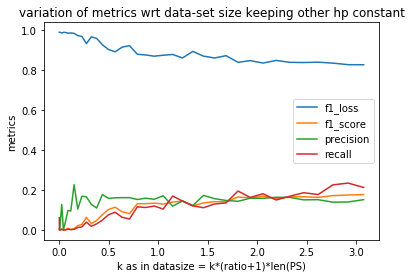

value of k at which f1 score is max =  3.077150631123659 corr precision =  0.151518315076828 corr_recall =  0.2123875766992569
value of k at which precision is max =  0.15147133922591174 max precision =  0.22612613439559937 corr_recall =  0.0033040305133908987


In [5]:
checkpoint = torch.load("/content/drive/My Drive/data_sizes_n.pt")
METRICS = checkpoint['metrics']
data_sizes_interval = checkpoint['data_sizes_interval']
print(data_sizes_interval)
plt.plot(data_sizes_interval, METRICS[0], label='f1_loss')
plt.plot(data_sizes_interval, METRICS[1], label='f1_score')
plt.plot(data_sizes_interval, METRICS[2], label='precision')
plt.plot(data_sizes_interval, METRICS[3], label='recall')
plt.title('variation of metrics wrt data-set size keeping other hp constant')
plt.xlabel('k as in datasize = k*(ratio+1)*len(PS)')
plt.ylabel('metrics')
plt.legend()
plt.show()
k_max_f1 = data_sizes_interval[np.argmax(METRICS[1])]
max_f1 = METRICS[1][np.argmax(METRICS[1])]
corr_pr = METRICS[2][np.argmax(METRICS[1])]
corr_recall = METRICS[3][np.argmax(METRICS[1])]

print('value of k at which f1 score is max = ', k_max_f1, 'corr precision = ', corr_pr, 'corr_recall = ', corr_recall)

max_pr_index = np.argmax(METRICS[2])
data_sizes_max_pr = data_sizes_interval[max_pr_index]
max_pr = METRICS[2][max_pr_index]
corr_recall = METRICS[3][max_pr_index]
print('value of k at which precision is max = ', data_sizes_max_pr, 'max precision = ', max_pr, 'corr_recall = ',corr_recall)

[4.01504636e-02 8.03009271e-02 1.20451391e-01 2.81053245e-01
 5.21956026e-01 8.43159735e-01 1.24466437e+00 1.72646993e+00
 2.28857642e+00 2.93098384e+00 3.65369218e+00 4.45670145e+00
 5.34001165e+00 6.30362278e+00 7.34753483e+00 8.47174781e+00
 9.67626172e+00 1.09610766e+01 1.23261923e+01 1.37716090e+01
 1.52973266e+01 1.69033452e+01 1.85896646e+01 2.03562850e+01
 2.22032063e+01 2.41304286e+01 2.61379518e+01 2.82257759e+01
 3.03939009e+01 3.26423269e+01 3.49710538e+01 3.73800816e+01
 3.98694103e+01 4.24390400e+01 4.50889706e+01 4.78192021e+01
 5.06297345e+01 5.35205679e+01 5.64917022e+01 5.95431375e+01]


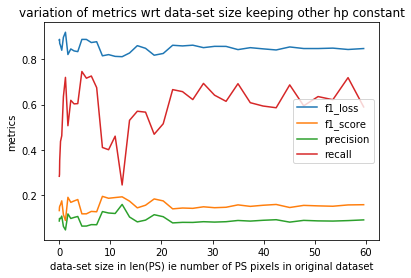

value of k at which f1 score is max =  8.471747810601217 corr precision =  0.12843064963817596 corr_recall =  0.4108167290687561
value of k at which precision is max =  12.326192312106985 max precision =  0.15992963314056396 corr_recall =  0.24566660821437836


In [6]:
checkpoint = torch.load("/content/drive/My Drive/data_sizes.pt")
METRICS = checkpoint['metrics']
data_sizes_interval = checkpoint['data_sizes_interval']
print(data_sizes_interval)
plt.plot(data_sizes_interval, METRICS[0], label='f1_loss')
plt.plot(data_sizes_interval, METRICS[1], label='f1_score')
plt.plot(data_sizes_interval, METRICS[2], label='precision')
plt.plot(data_sizes_interval, METRICS[3], label='recall')
plt.title('variation of metrics wrt data-set size keeping other hp constant')
plt.xlabel('data-set size in len(PS) ie number of PS pixels in original dataset')
plt.ylabel('metrics')
plt.legend()
plt.show()
k_max_f1 = data_sizes_interval[np.argmax(METRICS[1])]
max_f1 = METRICS[1][np.argmax(METRICS[1])]
corr_pr = METRICS[2][np.argmax(METRICS[1])]
corr_recall = METRICS[3][np.argmax(METRICS[1])]


print('value of k at which f1 score is max = ', k_max_f1, 'corr precision = ', corr_pr, 'corr_recall = ', corr_recall)

max_pr_index = np.argmax(METRICS[2])
data_sizes_max_pr = data_sizes_interval[max_pr_index]
max_pr = METRICS[2][max_pr_index]
corr_recall = METRICS[3][max_pr_index]
print('value of k at which precision is max = ', data_sizes_max_pr, 'max precision = ', max_pr, 'corr_recall = ',corr_recall)